Wnioski i sposrzeenia:

1. Największa oglądalność nominalna ma miejsce w sobotę i niedzielę (box plot rozkładu oglądalności tygoniowej) w godzinacch 18:00 - 23:00 (grafy oglądalności)
2. Stacje, poza MTV utrzymują pozim oglądalności w badanym okresie, charakteryzując się duza sezonowoscia (miesieczna, tygodniowa i dobowa, która mozna zaobserwowac na wykresach trendu i śreidniej oglądalnosci godzinowej)
3. Największe udziały w oglądalnosci calkowitej sa osiagane przez kanal KTV w godzinach nocnych i udział ten jest ~ dwa razy większy niz w godz. 18:00 - 23:00 (oczywiscie nominalna widownia jest wielokrotnie więsksza w prime time)
4. Programy takie jak Sitcom i Kabaret mają najsłabsze wyniki oglądalności (tabela wg gatunku) - do zbadania wpływ terminow emisji
5. Ranking pozycji programowych o najwyzszej ogladalnosci (tabela top) - rekomendacja, to dolaczeie danych ratingowych np Filmweb, ktore umozliwia bardziej doglebna analize
6. 


#### Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib.ticker as ticker
import seaborn as sns
color_pal = sns.color_palette()

from datetime import datetime, date, time, timedelta
from pytz import timezone
from calendar import day_name, month_name

from os.path import join

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from kp import ImportData, Description, Holidays, CreateFeatures
color_pal

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (0.996078431372549, 1.0, 0.7019607843137254),
 (0.7490196078431373, 0.7333333333333333, 0.8509803921568627),
 (0.9803921568627451, 0.5058823529411764, 0.4549019607843137),
 (0.5058823529411764, 0.6941176470588235, 0.8235294117647058),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.7372549019607844, 0.5098039215686274, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7686274509803922),
 (1.0, 0.9294117647058824, 0.43529411764705883)]

#### Import data

In [7]:
# import data

daily = ImportData.daily()
monthly = ImportData.monthly()
prog = ImportData.prog()
holidays = Holidays.holidays
descrription = Description.description

#### Exploring daily data set

In [4]:
# create date features for use in regression model from rgboost
df_daily=CreateFeatures.date_features(daily, True)

In [5]:
def create_bar_graph(df: pd.DataFrame, month_1: int, year_1: int, month_2: int, year_2: int, **kwargs):
    '''
    Function create bar graph with two series of average values to compare two periods of the same
    independent variance: RCH or AMR
    '''
    if 'c1' in kwargs.keys():
        c1 = kwargs['c1'] 
    else: c1:str='blue'
    if 'c2' in kwargs.keys():
        c2 = kwargs['c2']
    else: c2:str='orange'
    if 'col' in kwargs.keys():
        col = kwargs['col']
    else: col='RCH'

    def create_filter(df:pd.DataFrame, month: int, year: int) -> filter:
        return (df['month'] == month) & (df['year'] == year)

    f1 = create_filter(df=df, month=month_1, year=year_1)
    f2 = create_filter(df=df, month=month_2, year=year_2)

    df1 = df[f1].groupby(by=['hour']).agg({'RCH':np.mean, 'AMR':np.mean}).astype(int)
    df2 = df[f2].groupby(by=['hour']).agg({'RCH':np.mean, 'AMR':np.mean}).astype(int)
    
    months = {i:m for i,m in enumerate(list(month_name)[1:], start=1)}
    
    fig, ax = plt.subplots(figsize=(8,3))
    x = np.arange(24)
    width = 0.4
    ticks=[time(i,0).strftime('%H:%M') for i in range(0,24)]

    b1 = ax.bar(x - (width/2), df1[col], color=c1,
                        width=width, label=f'Average RCH on {months[month_1]} {year_1}')
    b2 = ax.bar(x + (width/2), df2[col], color=c2,
                        width=width, label=f'Average RCH on {months[month_2]} {year_2}')

    ax.set_ylabel('Average audience')
    ax.set_xticks(list(range(24)))
    ax.set_xticklabels(ticks, rotation=45, fontsize=8)
    ax.set_yticks(list(range(0,500_000, 50_000)))
    ax.set_yticklabels(['0', '50k', '100k', '150k', '200k', '250k', '300k', '350k', '400k', '450k'], fontsize=8)
    title = f'''Compare Audience KTV by "Day Part"\nbetween {months[month_1]} {year_1} and {months[month_2]} {year_2}'''
    ax.set_title(title, fontsize=10)
    ax.legend(frameon=False, fontsize=8)

    return fig, ax

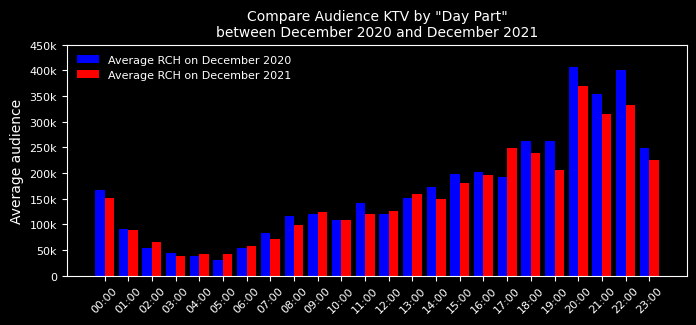

In [6]:
create_bar_graph(df_daily, 12,2020,12,2021, c2='red')
plt.show()

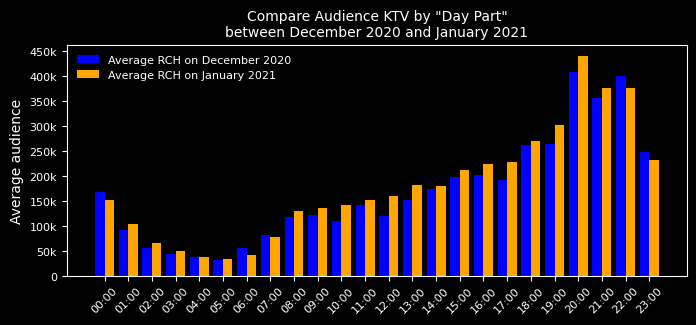

In [13]:
create_bar_graph(df_daily, 12,2020,1,2021,)
plt.show()

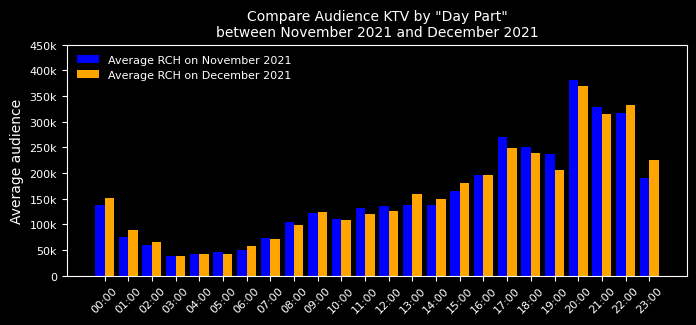

In [8]:
create_bar_graph(df_daily, 11,2021, 12,2021, col='RCH')
#create_bar_graph(df_daily, 11,2021, 12,2021, c2='green',c1='red', col='AMR')
plt.show()

In [15]:
df_daily.head()


,Channel,Date,DayPart,AMR,RCH,ATV,SHR,hour,dayofweek,month,quarter,year,dayofyear,holiday
0,KTV,2020-01-01,02:00,59189,140463,00:00:10,2.18,2,2,1,1,2020,1,0
1,KTV,2020-01-01,03:00,46974,118554,00:00:08,2.44,3,2,1,1,2020,1,0
2,KTV,2020-01-01,04:00,31644,39826,00:00:05,2.57,4,2,1,1,2020,1,0
3,KTV,2020-01-01,05:00,19679,62285,00:00:03,2.46,5,2,1,1,2020,1,0
4,KTV,2020-01-01,06:00,22828,72269,00:00:04,3.55,6,2,1,1,2020,1,0


#### Porównanie godzinowego udział w całkowitej widowni w 2021 roku w podziale miesięcznym

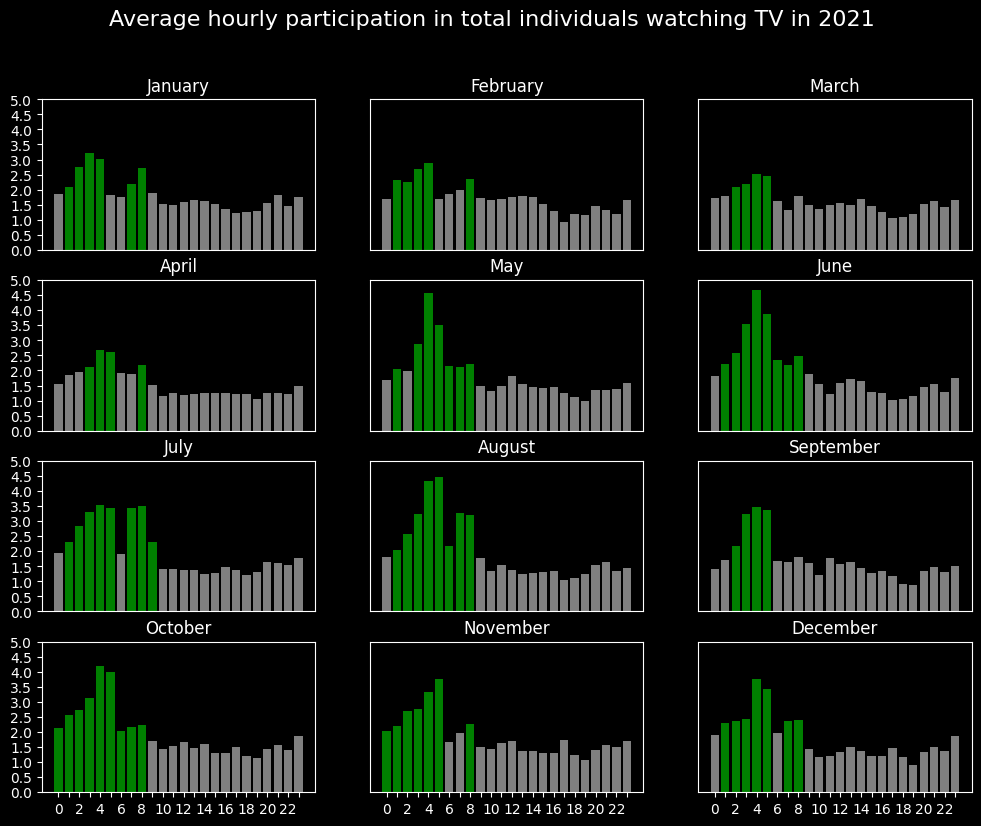

In [236]:
year=2021
axes = [(r,c) for r in range(4) for c in range(3)]
fig, axs = plt.subplots(4,3, figsize=(12,9))
bounder=2 # scores with value above value of bounder will by indicated on chart
m=1
for i,j in axes:
    # aggregate hourly average of SHR
    dfg = df_daily.query(f"year == {year} and month == {m}").groupby(by=['hour']).agg({'SHR':np.mean})
    # indicate bars with value above bounder
    colors = [('green' if h>bounder else 'grey') for h in dfg.SHR]
    # seting artist
    axs[i,j].bar(dfg.index, dfg.SHR, color=colors)
    axs[i,j].set_title(f'{month_name[m]}')
    axs[i,j].set_yticks(np.arange(0,5.5,0.5))
    if j > 0:
        axs[i,j].set_yticks([])
    if i < 3:
        axs[i,j].set_xticks([])
    else:
        axs[i,j].set_xticks(range(24))
        axs[i,j].set_xticklabels([(n if n%2==0 else None) for n in range(0,24)])
    m+=1

fig.suptitle('Average hourly participation in total individuals watching TV in 2021', fontsize=16)
plt.show()



**KTV** osiąga największe udziały w ogladalności, szczególnie w drugiej połowie 2021 roku, w godzinach nocnych. Udział w widzach w godzinach 3:00 - 6:00 jest - - większy niz w prime time.

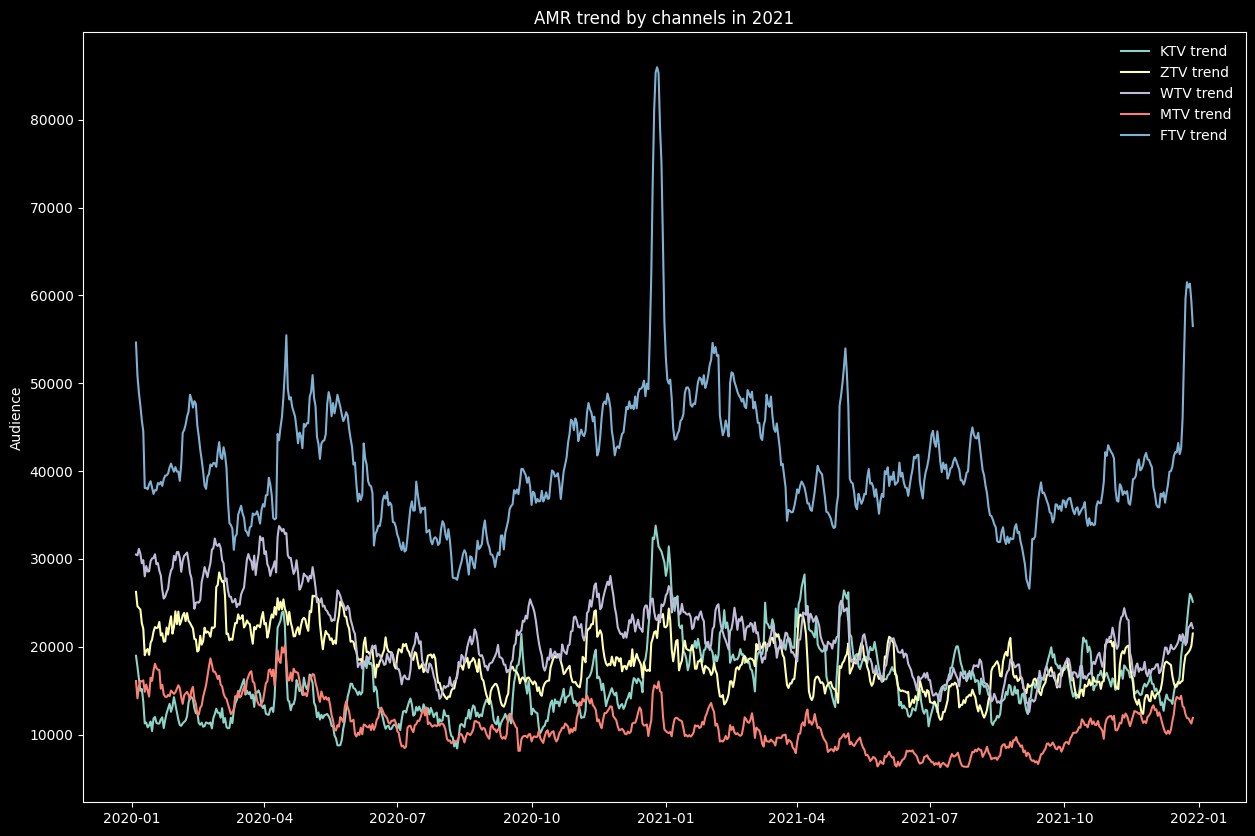

In [275]:
# compare trends of levele of audience between channels

channels = list(monthly.Channel.unique())
fig, ax = plt.subplots(figsize=(15,10))
for channel in channels[:]:
    vars()[f'monthly_{channel.lower()}'] = monthly.query(f"Channel == '{channel}'").set_index('Date').AMR.copy()
    vars()[f'decomposition_{channel.lower()}'] = sm.tsa.seasonal_decompose(vars()[f'monthly_{channel.lower()}'], 
                                                                        model = 'additive')
    #plt.plot(vars()[f'monthly_{channel.lower()}'].index, vars()[f'monthly_{channel.lower()}'], label = channel)
    plt.plot(vars()[f'decomposition_{channel.lower()}'].trend.index, 
                vars()[f'decomposition_{channel.lower()}'].trend, label = f'{channel} trend')
#monthly_reach.head()
plt.legend(frameon=False)
plt.title('AMR trend by channels in 2021')
plt.ylabel('Audience')
plt.show()

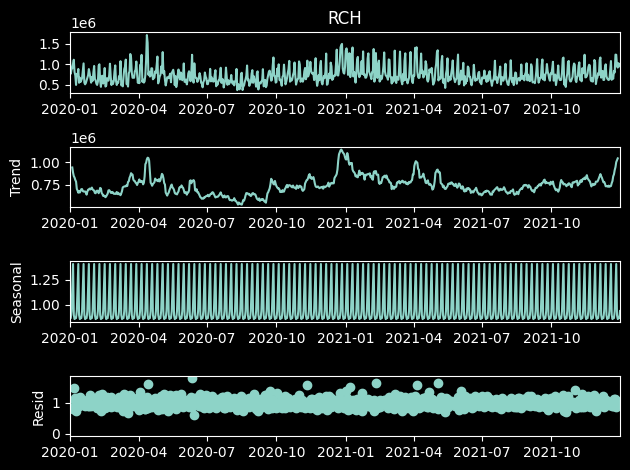

In [266]:
decomposition = sm.tsa.seasonal_decompose(mrch, model = 'multiplicative',)
fig = decomposition.plot()


In [17]:
# simple statistics for RCH and SHR
df_daily[['RCH', 'SHR']].describe()

,RCH,SHR
count,17544.000000,17544.000000
mean,147554.076037,1.693960
std,118612.861710,1.453091
min,0.000000,0.000000
25%,54645.000000,0.770000
50%,107609.500000,1.310000
75%,219402.500000,2.150000
max,753088.000000,16.850000


In [18]:

prog['description_array'] = prog.Description.str.split('/')
prog['description_len'] = prog.description_array.apply(lambda x: len(x))
prog['title'] = prog.description_array.apply(lambda x: x[0])
prog['title'] = prog['title'].str.strip()
prog.loc[prog.description_len ==3, 'category_cumulative'] = prog.loc[prog.description_len ==3, 'description_array']\
    .apply(lambda x: x[1])
prog = prog.drop(columns=['description_array'])

In [19]:
one=list(prog.title.value_counts(ascending=True).head(46).index)

In [20]:
description['AMR']

'Average Minute Rating: Average number of individuals who have seen a specific programme or daypart'

In [21]:
p=prog.set_index('Date', drop=False)
p.index.name = 'date'
create_features(p).sort_values(by=['RCH'], ascending=False).head(10)

,Target,Channel,Description,Date,Start time,main_category,AMR,SHR,RCH,ATS,description_len,title,category_cumulative,dayofweek,month,quarter,year,dayofyear,holiday
407,A 16-59,KTV,WEJSCIE SMOKA /FILM AKC.USA/,2021-11-20,20:00:03,Filmy fabularne,287739,0.0407,880106,00:32:00,3,WEJSCIE SMOKA,FILM AKC.USA,5,11,4,2021,324,0
219,A 16-59,KTV,AIR FORCE ONE /FILM SENS.USA/,2021-11-11,19:59:49,Filmy fabularne,221440,0.0307,768060,00:33:17,3,AIR FORCE ONE,FILM SENS.USA,3,11,4,2021,315,1
206,A 16-59,KTV,RONIN /FILM SENS.W.BRYT.USA/,2021-11-10,20:02:13,Filmy fabularne,137347,0.0213,756669,00:20:40,3,RONIN,FILM SENS.W.BRYT.USA,2,11,4,2021,314,0
101,A 16-59,KTV,MIS /FILM KOM.POL./,2021-11-05,20:00:03,Filmy fabularne,99746,0.0153,749195,00:14:57,3,MIS,FILM KOM.POL.,4,11,4,2021,309,0
523,A 16-59,KTV,WEJSCIE SMOKA /FILM AKC.USA/,2021-11-25,20:00:03,Filmy fabularne,167507,0.0249,744989,00:22:00,3,WEJSCIE SMOKA,FILM AKC.USA,3,11,4,2021,329,0
348,A 16-59,KTV,PSY /FILM SENS.POL./,2021-11-17,20:00:02,Filmy fabularne,65677,0.0096,680543,00:10:13,3,PSY,FILM SENS.POL.,2,11,4,2021,321,0
218,A 16-59,KTV,ASTERIX NA OLIMPIADZIE /FILM KOM.NIEM.FR.HISZP...,2021-11-11,17:35:32,Filmy fabularne,150516,0.0229,645149,00:25:49,3,ASTERIX NA OLIMPIADZIE,FILM KOM.NIEM.FR.HISZP.BEL.WL.,3,11,4,2021,315,1
271,A 16-59,KTV,ASTERIX NA OLIMPIADZIE /FILM KOM.NIEM.FR.HISZP...,2021-11-14,13:50:15,Filmy fabularne,131801,0.0227,643823,00:22:40,3,ASTERIX NA OLIMPIADZIE,FILM KOM.NIEM.FR.HISZP.BEL.WL.,6,11,4,2021,318,0
118,A 16-59,KTV,JURASSIC PARK /FILM SF USA/,2021-11-06,20:00:03,Filmy fabularne,118196,0.0168,643658,00:21:46,3,JURASSIC PARK,FILM SF USA,5,11,4,2021,310,0
8,A 16-59,KTV,PARK JURAJSKI /FILM SENS.USA/,2021-11-01,17:31:54,Filmy fabularne,138035,0.0202,635457,00:25:45,3,PARK JURAJSKI,FILM SENS.USA,0,11,4,2021,305,1


In [22]:
avg_amr=p.groupby(by=['title']).agg({'AMR':np.sum}).sort_values(by='AMR',ascending=False)\
    .join(p.title.value_counts())\
        .rename(columns={'title':'broadcast_quantity'})
avg_amr['average_amr'] = (avg_amr.AMR/avg_amr.broadcast_quantity)//1
rank_20=avg_amr.sort_values(by='average_amr', ascending=False).head(20)
rank_20.Name = 'Top 20 programs in Nov 2021'
rank_20

,AMR,broadcast_quantity,average_amr
title,,,
WEJSCIE SMOKA,455246,2,227623.0
KARMAZYNOWY PRZYPLYW,306033,2,153016.0
AIR FORCE ONE,290600,2,145300.0
RYTUAL,288877,2,144438.0
JURASSIC PARK,276596,2,138298.0
PARK JURAJSKI,138035,1,138035.0
CO KRYJE PRAWDA,135210,1,135210.0
ASTERIX NA OLIMPIADZIE,516536,4,129134.0
STRASZNY FILM,127136,1,127136.0


In [23]:
tail_20 = avg_amr.sort_values(by='average_amr', ascending=True).head(20)
tail_20

,AMR,broadcast_quantity,average_amr
title,,,
JASKINIA ZOLWI,528,1,528.0
KRZYZOWKA,3441,1,3441.0
ME VOY,7436,2,3718.0
CHOPIN PRAGNIENIE MILOSCI,4268,1,4268.0
SALA SAMOBOJCOW,8855,2,4427.0
KURA,16723,3,5574.0
MOWA PTAKOW,18433,3,6144.0
ZAGINIONY SKARB JESSEGO JAMESA,6426,1,6426.0
HEL,7224,1,7224.0


In [24]:
avg_amr_cat=p.groupby(by=['main_category']).agg({'AMR':np.sum}).sort_values(by='AMR',ascending=False)\
    .join(p.main_category.value_counts())\
        .rename(columns={'main_category':'broadcast_quantity'})
avg_amr_cat['average_amr'] = ((avg_amr_cat.AMR/avg_amr_cat.broadcast_quantity)//1).astype(int)
avg_amr_cat.sort_values(by='average_amr', ascending=False)

,AMR,broadcast_quantity,average_amr
main_category,,,
Seriale,9694222,170,57024
Filmy fabularne,11918635,222,53687
Film/serial dokumentalny - podrozniczy - przyrodniczy,6018615,113,53262
Komunikaty/ogloszenia,85409,2,42704
Telenowele fabularne,2117240,64,33081
Sitcom,709497,32,22171
Kabaret,422239,26,16239


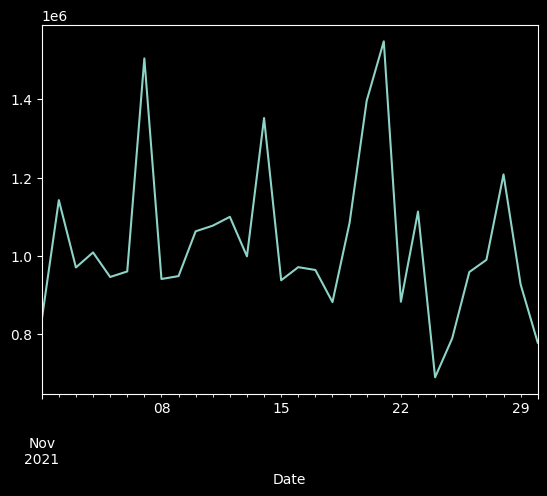

In [25]:
amr_nov = p.groupby(by=['Date']).agg({'AMR':np.sum})
ax = amr_nov.plot(kind='line')
ax.legend().remove()


In [30]:
p=p.join(p.index.isocalendar())

In [283]:
p.head()


,Target,Channel,Description,Date,Start time,main_category,AMR,SHR,RCH,ATS,description_len,title,category_cumulative,year,week,day
date,,,,,,,,,,,,,,,,
2021-11-01,A 16-59,KTV,LATA DWUDZIESTE LATA TRZYDZIESTE /FILM KOM.MUZ...,2021-11-01,02:00:00,Filmy fabularne,15417,0.0246,54588,00:27:32,3,LATA DWUDZIESTE LATA TRZYDZIESTE,FILM KOM.MUZ.POL.,2021,44,1
2021-11-01,A 16-59,KTV,LATA DWUDZIESTE LATA TRZYDZIESTE /FILM KOM.MUZ...,2021-11-01,02:00:00,Filmy fabularne,15417,0.0246,54588,00:27:32,3,LATA DWUDZIESTE LATA TRZYDZIESTE,FILM KOM.MUZ.POL.,2021,44,1
2021-11-01,A 16-59,KTV,LATA DWUDZIESTE LATA TRZYDZIESTE /FILM KOM.MUZ...,2021-11-01,02:00:00,Filmy fabularne,15417,0.0246,54588,00:27:32,3,LATA DWUDZIESTE LATA TRZYDZIESTE,FILM KOM.MUZ.POL.,2021,44,1
2021-11-01,A 16-59,KTV,LATA DWUDZIESTE LATA TRZYDZIESTE /FILM KOM.MUZ...,2021-11-01,02:00:00,Filmy fabularne,15417,0.0246,54588,00:27:32,3,LATA DWUDZIESTE LATA TRZYDZIESTE,FILM KOM.MUZ.POL.,2021,44,1
2021-11-01,A 16-59,KTV,LATA DWUDZIESTE LATA TRZYDZIESTE /FILM KOM.MUZ...,2021-11-01,02:00:00,Filmy fabularne,15417,0.0246,54588,00:27:32,3,LATA DWUDZIESTE LATA TRZYDZIESTE,FILM KOM.MUZ.POL.,2021,44,1


In [10]:
def create_features(df:pd.DataFrame) -> pd.DataFrame:
    '''
    Create time series features based on time series index.
    '''
    df=df.copy()
    df['dayofweek'] = df.index.dayofweek # 0 : Monday, 6 : Sunday
    df['weeknumber'] = df.index.isocalendar().week.astype(int)
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df = df.merge(holidays['holiday'], left_index=True, right_index=True, how='left')
    df['holiday']=df['holiday'].fillna(0)
    df['holiday'] = df['holiday'].astype(int)
    return df

In [11]:
monthly = monthly.sort_values(by='Date')
monthly_reach = monthly.set_index('Date')[['Channel', 'RCH']]
monthly_reach_ktv = monthly_reach.query("Channel == 'KTV'").drop(columns=['Channel'])
monthly_reach_ktv=create_features(monthly_reach_ktv)

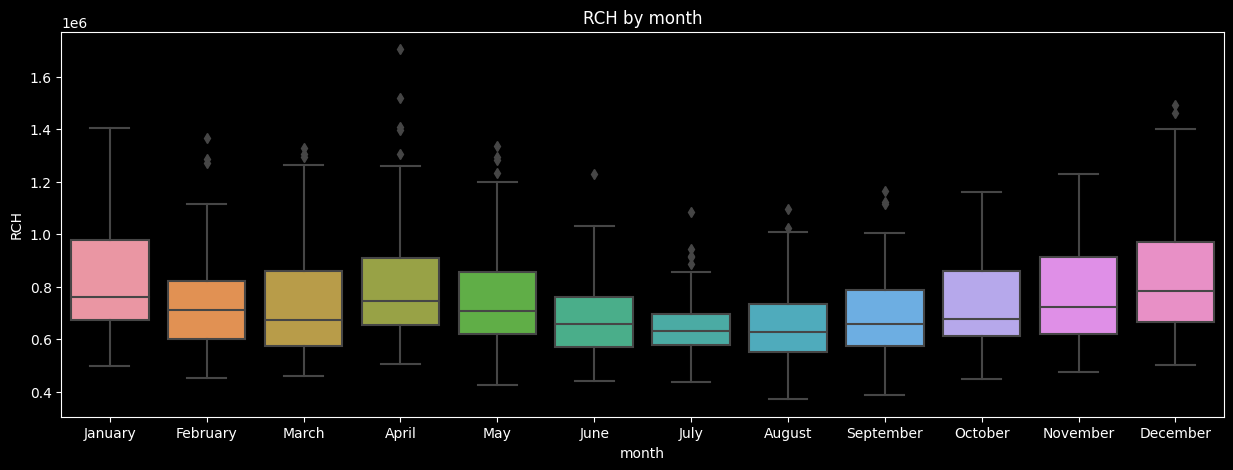

In [12]:
fig, ax = plt.subplots(figsize = (15,5))
ax=sns.boxplot(data = monthly_reach_ktv, x='month', y='RCH')
ax.set_xticklabels(list(month_name)[1:])
ax.set_title("RCH by month")
plt.show()

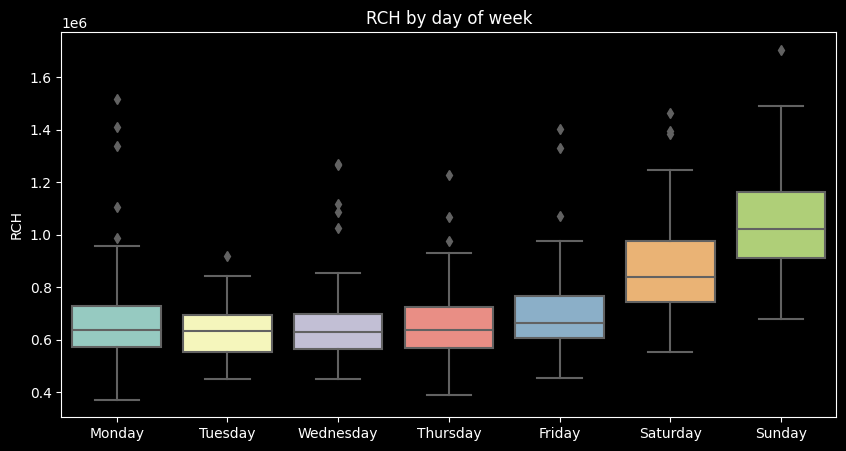

In [13]:
fig, ax = plt.subplots(figsize = (10,5))
ax=sns.boxplot(data = monthly_reach_ktv, x='dayofweek', y='RCH')
ax.set_xticklabels(list(day_name))
ax.set_xlabel(None)
ax.set_title("RCH by day of week")
plt.show()

In [17]:
monthly_reach=create_features(monthly_reach)[['Channel', 'RCH', 'month', 'year']]
viewership = monthly_reach.groupby(by=['year', 'month', 'Channel']).agg({'RCH':['sum', 'mean']})
channels = monthly_reach.Channel.unique()

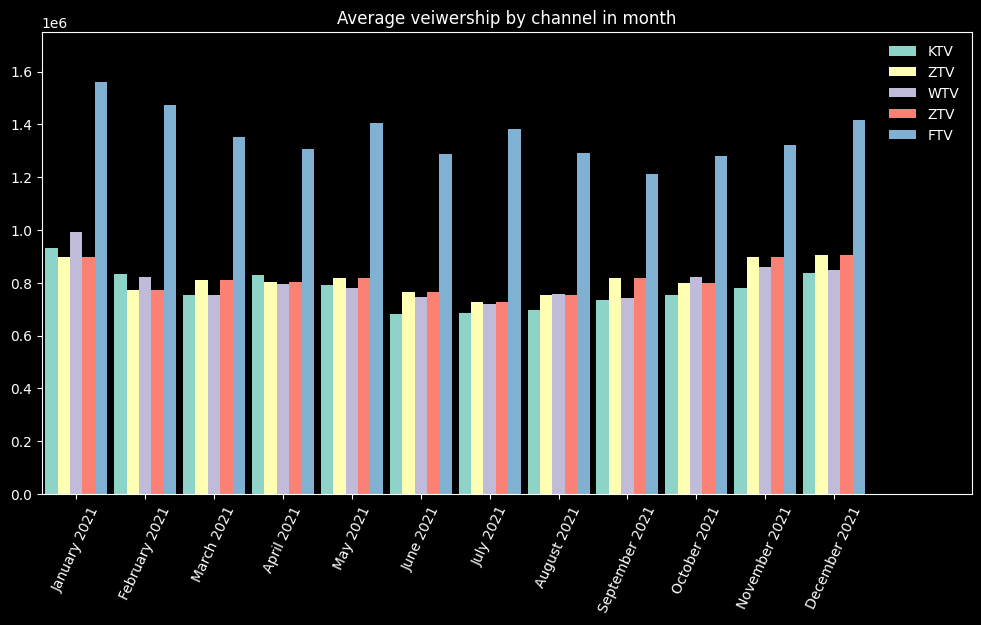

In [18]:
import matplotlib as mpl
cmap=mpl.colormaps['tab10']

channels = list(channels)
labels=[m + ' ' + y for y in ['2020', '2021'] for m in list(month_name)[1:] ]
ktv = viewership.xs('KTV', level=2)[[('RCH', 'mean')]].values
ztv = viewership.xs('ZTV', level=2)[[('RCH', 'mean')]].values
ftv = viewership.xs('FTV', level=2)[[('RCH', 'mean')]].values
mtv = viewership.xs('MTV', level=2)[[('RCH', 'mean')]].values
wtv = viewership.xs('WTV', level=2)[[('RCH', 'mean')]].values

x=np.arange(ktv.shape[0])
width=0.18

fig, ax = plt.subplots(figsize=(12,6))
b1 = ax.bar(x-(width/2)*4, ktv.flatten(), width, label='KTV')
b2 = ax.bar(x-(width/2)*2, ztv.flatten(), width, label='ZTV', )
b3 = ax.bar(x, wtv.flatten(), width, label='WTV', )
b4 = ax.bar(x+(width/2)*2, ztv.flatten(), width, label='ZTV', )
b5 = ax.bar(x+(width/2)*4, ftv.flatten(), width, label='FTV', )


ax.set_xticks(range(24))
ax.set_xticklabels(labels, rotation=65)
ax.set_xlim(11.5,25)
ax.set_title('Average veiwership by channel in month')
plt.legend(frameon=False)
plt.show()